# Notebook to look for target diseases related with a specific drug use

## Obtain eids and start and end era per drug

Using omop drug era database

In [ ]:
import pyspark
import dxpy
import dxdata
from pyspark.sql import functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import seaborn as sns

Import to current directory:
- mappings/drug_era/drug_era_atc.tsv
- src/project_permed

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df_ATC = pd.read_csv("drug_era_atc.tsv", sep="\t")

# Convert concept_name and drugs_to_filter to lowercase for case-insensitive filtering
df_ATC["concept_name_lower"] = df_ATC["concept_name"].str.lower()

# List of drugs to filter
drugs_to_filter = [
    "Loperamide",
    "Morphine",
    "Methadone",
    "Fentanyl",
    "Sufentanil",
    "3-Methylfentanyl",
    "3-Methylthiofentanyl",
    "Alfentanil",
    "Alvimopan",
    "Amisulpride",
    "Amitriptyline",
    "Anileridine",
    "Aripiprazole",
    "Buprenorphine",
    "Butorphanol",
    "Butyrfentanyl",
    "Cannabidiol",
    "Carfentanil",
    "Codeine",
    "Dextromethorphan",
    "Dextropropoxyphene",
    "Dezocine",
    "Diamorphine",
    "Dihydromorphine",
    "Dimethylthiambutene",
    "Diphenoxylate",
    "Diprenorphine",
    "Eluxadoline",
    "Epicept Np-1",
    "Ethylmorphine",
    "Etorphine",
    "Hydrocodone",
    "Hydromorphone",
    "Ketamine",
    "Ketobemidone",
    "Li-301",
    "Levacetylmethadol",
    "Levallorphan",
    "Levorphanol",
    "Loxicodegol",
    "Cannabis",
    "Meperidine",
    "Metenkefalin",
    "Methadyl Acetate",
    "Methylnaltrexone",
    "Morphine Glucuronide",
    "Nabiximols",
    "Nalbuphine",
    "Naldemedine",
    "Nalmefene",
    "Naloxegol",
    "Naloxone",
    "Naltrexone",
    "Oliceridine",
    "Ondansetron",
    "Opium",
    "Oxycodone",
    "Oxymorphone",
    "Pentazocine",
    "Pentoxyverine",
    "Pholcodine",
    "Remifentanil",
    "Samidorphan",
    "Tapentadol",
    "Tianeptine",
    "Tramadol",
    "Trimebutine",
    "V1003",
]
drugs_to_filter_lower = {drug.lower() for drug in drugs_to_filter}

# Filter rows where the lowercase drug name is in the lowercase list of drugs to filter
filtered_df_ATC = df_ATC[df_ATC["concept_name"].isin(drugs_to_filter_lower)]

# Identify drugs that do not appear in the dataframe
missing_drugs = drugs_to_filter_lower - set(df_ATC["concept_name_lower"])

# Print a message if there are missing drugs
if missing_drugs:
    print(
        f"The following drugs were not found in the dataset: {', '.join(missing_drugs)}"
    )

# Drop the temporary lowercase column to keep the original dataframe clean
df_ATC.drop(columns=["concept_name_lower"], inplace=True)

# Select the required columns and rename _c13 to ATC
filtered_df_ATC = filtered_df_ATC[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df_ATC.rename(columns={"_c13": "ATC"}, inplace=True)

display(filtered_df_ATC)

The following drugs were not found in the dataset: carfentanil, 3-methylthiofentanyl, methylnaltrexone, alvimopan, eluxadoline, epicept np-1, dihydromorphine, tianeptine, nabiximols, naldemedine, oliceridine, samidorphan, dezocine, li-301, diprenorphine, levallorphan, oxymorphone, butorphanol, nalbuphine, loxicodegol, opium, remifentanil, v1003, ketobemidone, anileridine, diamorphine, morphine glucuronide, dextropropoxyphene, levorphanol, metenkefalin, trimebutine, sufentanil, ethylmorphine, cannabis, hydrocodone, methadyl acetate, 3-methylfentanyl, butyrfentanyl, pentoxyverine, levacetylmethadol, dimethylthiambutene, etorphine


,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03


In [3]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df_ATC["ATC_First_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df_ATC["ATC_Second_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df_ATC["First_Level_Name"] = filtered_df_ATC["ATC_First_Level"].map(
    atc_1st_level
)
filtered_df_ATC["Second_Level_Name"] = filtered_df_ATC["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df_ATC

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12,N,N05,Nervous System,Psycholeptics
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03,A,A06,Alimentary Tract and Metabolism,Drugs for Constipation
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09,N,N06,Nervous System,Psychoanaleptics
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03,N,N01,Nervous System,Anesthetics
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."


In [4]:
# Save the filtered table to a new file
filtered_df_ATC.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [5]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [6]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' table
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [7]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[930916,
 1154029,
 1102527,
 1103640,
 757688,
 45774613,
 710062,
 785649,
 991876,
 1714319,
 1000560,
 19014158,
 19024213,
 19026459,
 1133201,
 1103314,
 19057607,
 19059528,
 1114220,
 1130585,
 1510417,
 1201620,
 1119510,
 1126658,
 1110410,
 1124957]

In [ ]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(F.col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", F.to_date(F.col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", F.to_date(F.col("drug_era_end_date"), "dd/MM/yyyy"))

# Remove duplicates in drug_mapping_df based on 'drug_concept_id' and 'concept_name'
drug_mapping_df = drug_mapping_df.drop_duplicates(
    subset=["drug_concept_id", "concept_name"]
)

# Convert Pandas DataFrame (drug_mapping_df) to Spark DataFrame
drug_mapping_spark_df = spark.createDataFrame(drug_mapping_df)

# Ensure "drug_concept_id" is the same type in both DataFrames
filtered_df_era = filtered_df_era.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)
drug_mapping_spark_df = drug_mapping_spark_df.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)

# Perform the join with drug_mapping_df on "drug_concept_id"
filtered_df_era = filtered_df_era.join(
    drug_mapping_spark_df.select(
        "drug_concept_id", "concept_name"
    ),  # Select only necessary columns
    on="drug_concept_id",
    how="left",
)

# Rename the 'concept_name' column to 'drug'
filtered_df_era = filtered_df_era.withColumnRenamed("concept_name", "drug")

# Sort by "drug_era_start_date"
filtered_df_era = filtered_df_era.orderBy("drug_era_start_date")

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+---------------+-------------+-------------------+-----------------+-------------------+--------+-------------+
|drug_concept_id|drug_era_id  |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug         |
+---------------+-------------+-------------------+-----------------+-------------------+--------+-------------+
|991876         |652835088928 |1990-01-01         |1990-01-30       |1                  |0       |loperamide   |
|1201620        |1597727924666|1990-01-01         |1990-01-30       |1                  |0       |codeine      |
|991876         |1486058743225|1990-01-01         |1990-01-06       |1                  |0       |loperamide   |
|991876         |1314260071294|1990-01-01         |1990-01-12       |1                  |0       |loperamide   |
|1201620        |601295454371 |1990-01-02         |1990-01-31       |1                  |0       |codeine      |
|1201620        |1262720440376|1990-01-02         |1990-01-31       |1                  |0      

869262

In [9]:
# Filter for rows where 'drug' contains 'morphine' or 'codeine' (case-insensitive)
filtered_df_era_morphine_codeine = filtered_df_era.filter(
    F.col("drug").rlike("(?i)morphine|codeine")
)
# Show the result of the filter
filtered_df_era_morphine_codeine.drop("eid").show(truncate=False)
filtered_df_era_morphine_codeine.count()

+---------------+-------------+-------------------+-----------------+-------------------+--------+-------+
|drug_concept_id|drug_era_id  |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug   |
+---------------+-------------+-------------------+-----------------+-------------------+--------+-------+
|1201620        |1597727924666|1990-01-01         |1990-01-30       |1                  |0       |codeine|
|1201620        |601295454371 |1990-01-02         |1990-01-31       |1                  |0       |codeine|
|1201620        |1262720440376|1990-01-02         |1990-01-31       |1                  |0       |codeine|
|1201620        |128849029717 |1990-01-03         |1990-02-01       |1                  |0       |codeine|
|1201620        |1434519131532|1990-01-03         |1990-02-01       |1                  |0       |codeine|
|1201620        |481036398140 |1990-01-03         |1990-02-01       |1                  |0       |codeine|
|1201620        |1571958076415|1990-0

421762

## Obtain eids and diagnosis start day per disease

In [ ]:
# Load the 'Date of first in-patient diagnosis - ICD10' table
hesin_diag = dataset["hesin_diag"]
hesin = dataset["hesin"]

# Extract all field names from the table
field_names_hesin_diag = [f.name for f in hesin_diag.fields]
field_names_hesin = [f.name for f in hesin.fields]

# Retrieve the fields
diagnosis_df = hesin_diag.retrieve_fields(
    names=field_names_hesin_diag, engine=dxdata.connect()
)
hesin_df = hesin.retrieve_fields(names=field_names_hesin, engine=dxdata.connect())

print(diagnosis_df.columns)
print(hesin_df.columns)

# Filter the HESIN_DIAG table to include only the EIDs in filtered_df_era_morphine_codeine
eid_list = (
    filtered_df_era_morphine_codeine.select("eid")
    .distinct()
    .rdd.flatMap(lambda x: x)
    .collect()
)
filtered_diagnosis_df = diagnosis_df.filter(diagnosis_df["eid"].isin(eid_list))

print(f"Number of entries era {filtered_diagnosis_df.count()}")
filtered_diagnosis_df.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['dnx_hesin_diag_id', 'dnx_hesin_id', 'eid', 'ins_index', 'arr_index', 'level', 'diag_icd9', 'diag_icd9_nb', 'diag_icd10', 'diag_icd10_nb']
['dnx_hesin_id', 'eid', 'ins_index', 'epiorder', 'spell_index', 'spell_seq', 'spelbgin', 'spelend', 'speldur', 'pctcode', 'gpprpct', 'category', 'elecdate', 'dsource', 'elecdur', 'admidate', 'admimeth_uni', 'admimeth', 'admisorc_uni', 'admisorc', 'firstreg', 'classpat_uni', 'classpat', 'intmanag_uni', 'source', 'intmanag', 'mainspef_uni', 'mainspef', 'tretspef_uni', 'tretspef', 'operstat', 'disdate', 'dismeth_uni', 'dismeth', 'disdest_uni', 'epistart', 'disdest', 'carersi', 'epiend', 'epidur', 'bedyear', 'epistat', 'epitype']
Number of entries era 4933602
+-----------------+------------+---------+---------+-----+---------+------------+----------+-------------+
|dnx_hesin_diag_id|dnx_hesin_id|ins_index|arr_index|level|diag_icd9|diag_icd9_nb|diag_icd10|diag_icd10_nb|
+-----------------+------------+---------+---------+-----+---------+------------+---

In [ ]:
# Perform a left join to keep only rows from filtered_diagnosis_df and add epistart from hesin_df
filtered_diagnosis_df = filtered_diagnosis_df.join(
    hesin_df.select("eid", "ins_index", "epistart"),  # Selecting only necessary columns
    on=["eid", "ins_index"],
    how="left",
)

print(f"Number of entries era {filtered_diagnosis_df.count()}")
filtered_diagnosis_df.drop("eid").show(3, truncate=False)

Number of entries era 4933602
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
|ins_index|dnx_hesin_diag_id|dnx_hesin_id|arr_index|level|diag_icd9|diag_icd9_nb|diag_icd10|diag_icd10_nb|epistart  |
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
|42       |1273199-42-1     |1273199-42  |1        |2    |NULL     |NULL        |M059      |NULL         |2019-03-01|
|4        |1898529-4-2      |1898529-4   |2        |2    |NULL     |NULL        |Z901      |NULL         |2010-05-04|
|27       |1144086-27-3     |1144086-27  |3        |2    |NULL     |NULL        |I209      |NULL         |2017-11-02|
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
only showing top 3 rows



In [ ]:
# Select only the required columns
final_diagnosis_df = filtered_diagnosis_df.select(
    "eid", "ins_index", "arr_index", "diag_icd10", "epistart"
)
# Format date columns
final_diagnosis_df = final_diagnosis_df.withColumn(
    "epistart", F.to_date(F.col("epistart"), "dd/MM/yyyy")
)

# Show the results
final_diagnosis_df.drop("eid").show(3, truncate=False)
print(f"Number of entries era {final_diagnosis_df.count()}")

+---------+---------+----------+----------+
|ins_index|arr_index|diag_icd10|epistart  |
+---------+---------+----------+----------+
|42       |1        |M059      |2019-03-01|
|4        |2        |Z901      |2010-05-04|
|27       |3        |I209      |2017-11-02|
+---------+---------+----------+----------+
only showing top 3 rows

Number of entries era 4933602


In [13]:
final_diagnosis_df = final_diagnosis_df.dropDuplicates(
    ["eid", "diag_icd10", "epistart"]
)

final_diagnosis_df.drop("eid").show(truncate=False)
print(f"Number of entries after removing duplicates: {final_diagnosis_df.count()}")

+---------+---------+----------+----------+
|ins_index|arr_index|diag_icd10|epistart  |
+---------+---------+----------+----------+
|3        |2        |Z824      |2014-10-08|
|19       |2        |I709      |2022-01-27|
|20       |7        |N19       |2019-04-18|
|47       |0        |C829      |2018-04-23|
|18       |8        |M199      |2018-09-27|
|54       |7        |I679      |2021-08-11|
|2        |1        |I10       |2019-06-16|
|29       |0        |K429      |2006-03-03|
|8        |0        |H402      |2012-01-06|
|12       |8        |F329      |2021-11-10|
|6        |18       |M4780     |2020-03-04|
|6        |1        |E780      |2016-08-02|
|8        |0        |R195      |2019-03-07|
|29       |1        |E114      |2009-09-23|
|42       |0        |N47       |2017-08-21|
|18       |4        |C788      |2011-11-04|
|60       |18       |Z926      |2022-02-12|
|15       |3        |I259      |2014-01-26|
|26       |0        |R194      |2017-06-02|
|41       |1        |Z850      |

## Now join the drug_era and diagnosis tables and filter the diagnosis base on dates
We want to keep the diagonsis that start in the middle of a drug era or maximum of 30 days before

In [ ]:
# Perform a join on "eid" with the drug era df
joined_df_era_diagnosis = filtered_df_era_morphine_codeine.join(
    final_diagnosis_df.select(
        "eid", "diag_icd10", "epistart"
    ),  # Selecting only necessary columns
    on="eid",
    how="left",
)

# Show the final DataFrame
joined_df_era_diagnosis.drop("eid").show(truncate=False)
print(f"Number of entries era {joined_df_era_diagnosis.count()}")

+---------------+------------+-------------------+-----------------+-------------------+--------+-------+----------+----------+
|drug_concept_id|drug_era_id |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug   |diag_icd10|epistart  |
+---------------+------------+-------------------+-----------------+-------------------+--------+-------+----------+----------+
|1201620        |773094182482|2011-10-05         |2011-10-09       |1                  |0       |codeine|E039      |2007-05-05|
|1201620        |773094182482|2011-10-05         |2011-10-09       |1                  |0       |codeine|Y483      |2007-05-05|
|1201620        |773094182482|2011-10-05         |2011-10-09       |1                  |0       |codeine|N63       |2004-05-04|
|1201620        |773094182482|2011-10-05         |2011-10-09       |1                  |0       |codeine|E780      |2010-02-15|
|1201620        |773094182482|2011-10-05         |2011-10-09       |1                  |0       |codeine

In [ ]:
# Filter where diagnosis_date is within (drug_era_start_date - 1 month) and (drug_era_end_date)
filtered_df_era_diagnosis = joined_df_era_diagnosis.filter(
    (
        F.col("epistart") >= F.date_sub(F.col("drug_era_start_date"), 30)
    )  # Up to 1 month before start date
    & (F.col("epistart") <= F.col("drug_era_end_date"))  # Within drug era
)
filtered_df_era_diagnosis.drop("eid").show(truncate=False)
print(f"Number of entries era {filtered_df_era_diagnosis.count()}")

+---------------+-------------+-------------------+-----------------+-------------------+--------+-------+----------+----------+
|drug_concept_id|drug_era_id  |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug   |diag_icd10|epistart  |
+---------------+-------------+-------------------+-----------------+-------------------+--------+-------+----------+----------+
|1201620        |1116691570675|2014-09-04         |2014-10-25       |2                  |0       |codeine|E780      |2014-09-11|
|1201620        |1116691570675|2014-09-04         |2014-10-25       |2                  |0       |codeine|M169      |2014-09-11|
|1201620        |429496730275 |2012-07-02         |2017-05-31       |66                 |884     |codeine|K449      |2014-11-26|
|1201620        |429496730275 |2012-07-02         |2017-05-31       |66                 |884     |codeine|I10       |2014-11-26|
|1201620        |429496730275 |2012-07-02         |2017-05-31       |66                 |884     

In [16]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_filtered_df_era_diagnosis = filtered_df_era_diagnosis.toPandas()

In [17]:
pandas_filtered_df_era_diagnosis.drop("eid", axis=1)

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug,diag_icd10,epistart
0,1201620,1116691570675,2014-09-04,2014-10-25,2,0,codeine,E780,2014-09-11
1,1201620,1116691570675,2014-09-04,2014-10-25,2,0,codeine,M169,2014-09-11
2,1201620,429496730275,2012-07-02,2017-05-31,66,884,codeine,K449,2014-11-26
3,1201620,429496730275,2012-07-02,2017-05-31,66,884,codeine,I10,2014-11-26
4,1201620,429496730275,2012-07-02,2017-05-31,66,884,codeine,K573,2014-11-26
...,...,...,...,...,...,...,...,...,...
463588,1201620,1047972056841,2014-03-20,2014-08-12,4,35,codeine,J348,2014-04-11
463589,1201620,644245154208,2015-05-29,2015-09-16,3,25,codeine,M754,2015-07-31
463590,1201620,644245154208,2015-05-29,2015-09-16,3,25,codeine,K449,2015-07-31
463591,1201620,644245154208,2015-05-29,2015-09-16,3,25,codeine,T921,2015-07-31


In [ ]:
pandas_filtered_df_era_diagnosis = pandas_filtered_df_era_diagnosis.sort_values(
    by="drug_era_start_date"
)
pandas_filtered_df_era_diagnosis = (
    pandas_filtered_df_era_diagnosis.groupby(
        [
            "eid",
            "drug_era_id",
            "drug_era_start_date",
            "drug_era_end_date",
            "drug_exposure_count",
            "gap_days",
            "drug",
        ]
    )
    .agg(diag_icd10=("diag_icd10", list), epistarts=("epistart", list))
    .reset_index()
)

display(pandas_filtered_df_era_diagnosis.drop("eid", axis=1))

,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug,diag_icd10,epistarts
0,566935699735,2011-09-27,2011-10-30,1,0,codeine,"[M2332, M179]","[2011-09-19, 2011-09-19]"
1,979252592549,2013-02-06,2013-03-12,2,0,morphine,"[S2200, S2200, J459, R074, W109, W109, J459]","[2013-02-01, 2013-01-31, 2013-01-31, 2013-02-0..."
2,1116691570675,2014-09-04,2014-10-25,2,0,codeine,"[M169, E780]","[2014-09-11, 2014-09-11]"
3,1417339268251,2003-02-21,2003-03-22,1,0,codeine,"[R190, R190, I251, I251]","[2003-02-17, 2003-02-23, 2003-02-23, 2003-02-17]"
4,1142461315608,2014-09-01,2017-06-14,37,80,codeine,"[Z966, M5457, K219, Z721, G473, M819, Z139, M7...","[2017-05-15, 2017-05-15, 2017-05-15, 2016-10-1..."
...,...,...,...,...,...,...,...,...
59743,712964583296,2010-03-22,2010-07-17,4,21,codeine,[J329],[2010-05-08]
59744,292057829631,2005-04-25,2005-05-24,1,0,codeine,"[J459, I209, L600, Z538]","[2005-05-19, 2005-05-19, 2005-05-19, 2005-05-19]"
59745,463856468069,2009-09-21,2009-12-12,2,24,codeine,"[E780, F419, I251, Z951, E780, E780, E780, I25...","[2009-11-17, 2009-11-17, 2009-10-16, 2009-10-1..."
59746,498216243755,2011-03-02,2011-11-09,11,31,codeine,"[I200, I200]","[2011-02-24, 2011-02-28]"


In [ ]:
pandas_filtered_df_era_diagnosis = (
    pandas_filtered_df_era_diagnosis.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        drugs=("drug", list),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        diag_icd10=("diag_icd10", "sum"),
        epistarts=("epistarts", "sum"),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(pandas_filtered_df_era_diagnosis.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,diag_icd10,epistarts,exposure_counts,gap_days
0,1,[codeine],[2011-09-27],[2011-10-30],"[M2332, M179]","[2011-09-19, 2011-09-19]",[1],[0]
1,1,[morphine],[2013-02-06],[2013-03-12],"[S2200, S2200, J459, R074, W109, W109, J459]","[2013-02-01, 2013-01-31, 2013-01-31, 2013-02-0...",[2],[0]
2,1,[codeine],[2014-09-04],[2014-10-25],"[M169, E780]","[2014-09-11, 2014-09-11]",[2],[0]
3,1,[codeine],[2003-02-21],[2003-03-22],"[R190, R190, I251, I251]","[2003-02-17, 2003-02-23, 2003-02-23, 2003-02-17]",[1],[0]
4,4,"[codeine, codeine, codeine, morphine]","[2014-09-01, 2009-04-28, 2008-08-13, 2008-07-31]","[2017-06-14, 2014-07-08, 2009-01-08, 2008-08-11]","[Z966, M5457, K219, Z721, G473, M819, Z139, M7...","[2017-05-15, 2017-05-15, 2017-05-15, 2016-10-1...","[37, 72, 7, 1]","[80, 96, 20, 0]"
...,...,...,...,...,...,...,...,...
32773,2,"[codeine, codeine]","[2014-03-20, 2015-05-29]","[2014-08-12, 2015-09-16]","[J348, K219, K449, H729, Z864, N328, M754, K44...","[2014-04-11, 2014-02-19, 2014-02-19, 2014-04-1...","[4, 3]","[35, 25]"
32774,3,"[codeine, codeine, codeine]","[2013-11-01, 2008-12-22, 2011-02-18]","[2014-02-26, 2009-05-01, 2011-07-26]","[Z864, M179, Z966, K639, M2556, E780]","[2013-11-11, 2013-11-11, 2013-11-11, 2009-04-0...","[4, 4, 5]","[5, 16, 24]"
32775,1,[codeine],[2002-07-31],[2002-08-29],"[Q211, Q264]","[2002-07-25, 2002-07-25]",[1],[0]
32776,1,[codeine],[2010-03-22],[2010-07-17],[J329],[2010-05-08],[4],[21]


Add the diagnosis information to the original era dataframe to keep all drug eras

In [ ]:
filtered_df_era_morphine_codeine_pd = filtered_df_era_morphine_codeine.toPandas()
# Ensure 'eid' is of type int in both DataFrames
pandas_filtered_df_era_diagnosis["eid"] = pandas_filtered_df_era_diagnosis[
    "eid"
].astype(int)
filtered_df_era_morphine_codeine_pd["eid"] = filtered_df_era_morphine_codeine_pd[
    "eid"
].astype(int)

# Now perform the merge
filtered_with_diag_info = filtered_df_era_morphine_codeine_pd.merge(
    pandas_filtered_df_era_diagnosis[["eid", "diag_icd10", "epistarts"]],
    on="eid",
    how="left",
)

# Display the result without the 'eid' column
display(filtered_with_diag_info.drop("eid", axis=1))

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug,diag_icd10,epistarts
0,1201620,1597727924666,1990-01-01,1990-01-30,1,0,codeine,NaN,NaN
1,1201620,601295454371,1990-01-02,1990-01-31,1,0,codeine,NaN,NaN
2,1201620,1262720440376,1990-01-02,1990-01-31,1,0,codeine,"[R104, R14]","[1997-11-05, 1997-11-05]"
3,1201620,128849029717,1990-01-03,1990-02-01,1,0,codeine,"[I639, I846, I10, I678, G819, I10, I694, K644,...","[2015-02-11, 2015-12-23, 2015-02-11, 2015-02-1..."
4,1201620,1434519131532,1990-01-03,1990-02-01,1,0,codeine,NaN,NaN
...,...,...,...,...,...,...,...,...,...
421757,1201620,558345805315,2017-09-20,2017-10-19,1,0,codeine,"[D231, N23, I10, E780, K579]","[2016-04-01, 2014-02-03, 2014-02-03, 2014-02-0..."
421758,1201620,601295449619,2017-09-20,2017-10-19,1,0,codeine,NaN,NaN
421759,1201620,781684096456,2017-09-20,2017-10-19,1,0,codeine,NaN,NaN
421760,1201620,128849082881,2017-09-20,2017-10-19,1,0,codeine,NaN,NaN


In [ ]:
filtered_with_diag_info_grouped = (
    filtered_with_diag_info.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        drugs=("drug", list),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        diag_icd10=("diag_icd10", "first"),  # take only one list
        epistarts=("epistarts", "first"),  # take only one list
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)

display(filtered_with_diag_info_grouped.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,diag_icd10,epistarts,exposure_counts,gap_days
0,1,[codeine],[2004-12-20],[2004-12-28],None,None,[1],[0]
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]",None,None,"[1, 1]","[0, 0]"
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[M2332, M179]","[2011-09-19, 2011-09-19]","[6, 1, 1]","[0, 0, 0]"
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...",None,None,"[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]",None,None,"[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...",None,None,"[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...",[J329],[2010-05-08],"[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...",None,None,"[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[J459, I209, L600, Z538, E780, F419, I251, Z95...","[2005-05-19, 2005-05-19, 2005-05-19, 2005-05-1...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Total exposures per participant
# Convert all elements in 'exposure_counts' lists to integers
filtered_with_diag_info_grouped["exposure_counts"] = filtered_with_diag_info_grouped[
    "exposure_counts"
].apply(
    lambda x: [int(i) for i in x]  # Ensures all elements are integers
)

# Compute total_exposure_counts
filtered_with_diag_info_grouped["total_exposure_counts"] = (
    filtered_with_diag_info_grouped["exposure_counts"].apply(sum)
)

# Number of days medication is available (drug era duration - gap days)
# Convert string dates to datetime format
filtered_with_diag_info_grouped["start_dates_parsed"] = filtered_with_diag_info_grouped[
    "start_dates"
].apply(lambda x: pd.to_datetime(x))
filtered_with_diag_info_grouped["end_dates_parsed"] = filtered_with_diag_info_grouped[
    "end_dates"
].apply(lambda x: pd.to_datetime(x))
filtered_with_diag_info_grouped["gap_days"] = filtered_with_diag_info_grouped[
    "gap_days"
].apply(
    lambda x: [int(i) for i in x]  # Ensures all elements are integers
)


# Function to calculate available medication days accounting for overlaps
def calculate_available_days(row):
    start_dates = row["start_dates_parsed"]
    end_dates = row["end_dates_parsed"]
    gap_days = row["gap_days"]

    intervals = sorted(zip(start_dates, end_dates, gap_days))

    total_days = 0
    last_end = None  # Track last end date for overlap detection

    for start, end, gap in intervals:
        duration = (end - start).days - gap

        if last_end is None or start > last_end:  # No overlap
            total_days += duration
        else:  # Overlap case
            overlap = (last_end - start).days
            effective_days = max(0, duration - overlap)  # Remove overlap
            total_days += effective_days

        last_end = max(last_end, end) if last_end else end  # Update last end date

    return total_days


# Apply function to each row
filtered_with_diag_info_grouped["available_medication_days"] = (
    filtered_with_diag_info_grouped.apply(calculate_available_days, axis=1)
)

In [23]:
display(filtered_with_diag_info_grouped.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,diag_icd10,epistarts,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days
0,1,[codeine],[2004-12-20],[2004-12-28],None,None,[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]",None,None,"[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[M2332, M179]","[2011-09-19, 2011-09-19]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...",None,None,"[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]",None,None,"[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62
...,...,...,...,...,...,...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...",None,None,"[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...",[J329],[2010-05-08],"[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...",None,None,"[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[J459, I209, L600, Z538, E780, F419, I251, Z95...","[2005-05-19, 2005-05-19, 2005-05-19, 2005-05-1...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566


In [24]:
## Add diseases based on icd10 codes

In [ ]:
# Function to transform ICD-10 codes to level 1 format
def transform_icd10(icd10_list):
    if isinstance(icd10_list, list):
        return list(set(code[:3] for code in icd10_list if isinstance(code, str)))
    return []  # Extract first letter + 2 numbers and remove duplicates


# Apply the transformation to create the new column
filtered_with_diag_info_grouped["diag_icd10_level1"] = filtered_with_diag_info_grouped[
    "diag_icd10"
].apply(transform_icd10)
filtered_with_diag_info_grouped.drop("eid", axis=1)

,num_drug_era_id,drugs,start_dates,end_dates,diag_icd10,epistarts,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,diag_icd10_level1
0,1,[codeine],[2004-12-20],[2004-12-28],None,None,[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,[]
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]",None,None,"[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,[]
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[M2332, M179]","[2011-09-19, 2011-09-19]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,"[M17, M23]"
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...",None,None,"[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,[]
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]",None,None,"[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...",None,None,"[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,[]
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...",[J329],[2010-05-08],"[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,[J32]
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...",None,None,"[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,[]
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[J459, I209, L600, Z538, E780, F419, I251, Z95...","[2005-05-19, 2005-05-19, 2005-05-19, 2005-05-1...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,"[Z53, R07, L60, J45, H26, I20, I25, J44, E78, ..."


Download Data-Coding 19 from showcase: https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=19&nl=1 which is here icd10_coding.tsv

In [26]:
# Load the coding19 table from a TSV file (adjust the path if necessary)
icd10_coding = pd.read_csv("icd10_coding.tsv", sep="\t")
display(icd10_coding)

,coding,meaning,node_id,parent_id,selectable
0,A00,A00 Cholera,2860,230,Y
1,A000,"A00.0 Cholera due to Vibrio cholerae 01, biova...",2870,2860,Y
2,A001,"A00.1 Cholera due to Vibrio cholerae 01, biova...",2880,2860,Y
3,A009,"A00.9 Cholera, unspecified",2890,2860,Y
4,A01,A01 Typhoid and paratyphoid fevers,2900,230,Y
...,...,...,...,...,...
19185,Z992,Z99.2 Dependence on renal dialysis,191500,191470,Y
19186,Z993,Z99.3 Dependence on wheelchair,191510,191470,Y
19187,Z994,Z99.4 Dependence on artificial heart,191520,191470,Y
19188,Z998,Z99.8 Dependence on other enabling machines an...,191530,191470,Y


In [ ]:
# Explode diag_icd10 to have one disease per row
df_exploded = filtered_with_diag_info_grouped.explode("diag_icd10_level1")
# Merge on ICD-10 codes to get disease meanings
df_exploded = df_exploded.merge(
    icd10_coding, left_on="diag_icd10_level1", right_on="coding", how="left"
)

# Rename the column to meaning_disease
df_exploded.rename(columns={"meaning": "meaning_disease"}, inplace=True)
final_df_exploded = df_exploded[
    [
        "eid",
        "num_drug_era_id",
        "drugs",
        "total_exposure_counts",
        "available_medication_days",
        "diag_icd10_level1",
        "meaning_disease",
    ]
].copy()
display(final_df_exploded.drop("eid", axis=1))

,num_drug_era_id,drugs,total_exposure_counts,available_medication_days,diag_icd10_level1,meaning_disease
0,1,[codeine],1,8,NaN,NaN
1,2,"[codeine, codeine]",2,58,NaN,NaN
2,3,"[codeine, codeine, codeine]",8,121,M17,M17 Gonarthrosis [arthrosis of knee]
3,3,"[codeine, codeine, codeine]",8,121,M23,M23 Internal derangement of knee
4,6,"[codeine, codeine, codeine, codeine, codeine, ...",7,175,NaN,NaN
...,...,...,...,...,...,...
286076,8,"[codeine, codeine, codeine, codeine, codeine, ...",23,566,Z50,Z50 Care involving use of rehabilitation proce...
286077,8,"[codeine, codeine, codeine, codeine, codeine, ...",23,566,F41,F41 Other anxiety disorders
286078,8,"[codeine, codeine, codeine, codeine, codeine, ...",23,566,Z82,Z82 Family history of certain disabilities and...
286079,8,"[codeine, codeine, codeine, codeine, codeine, ...",23,566,Z95,Z95 Presence of cardiac and vascular implants ...


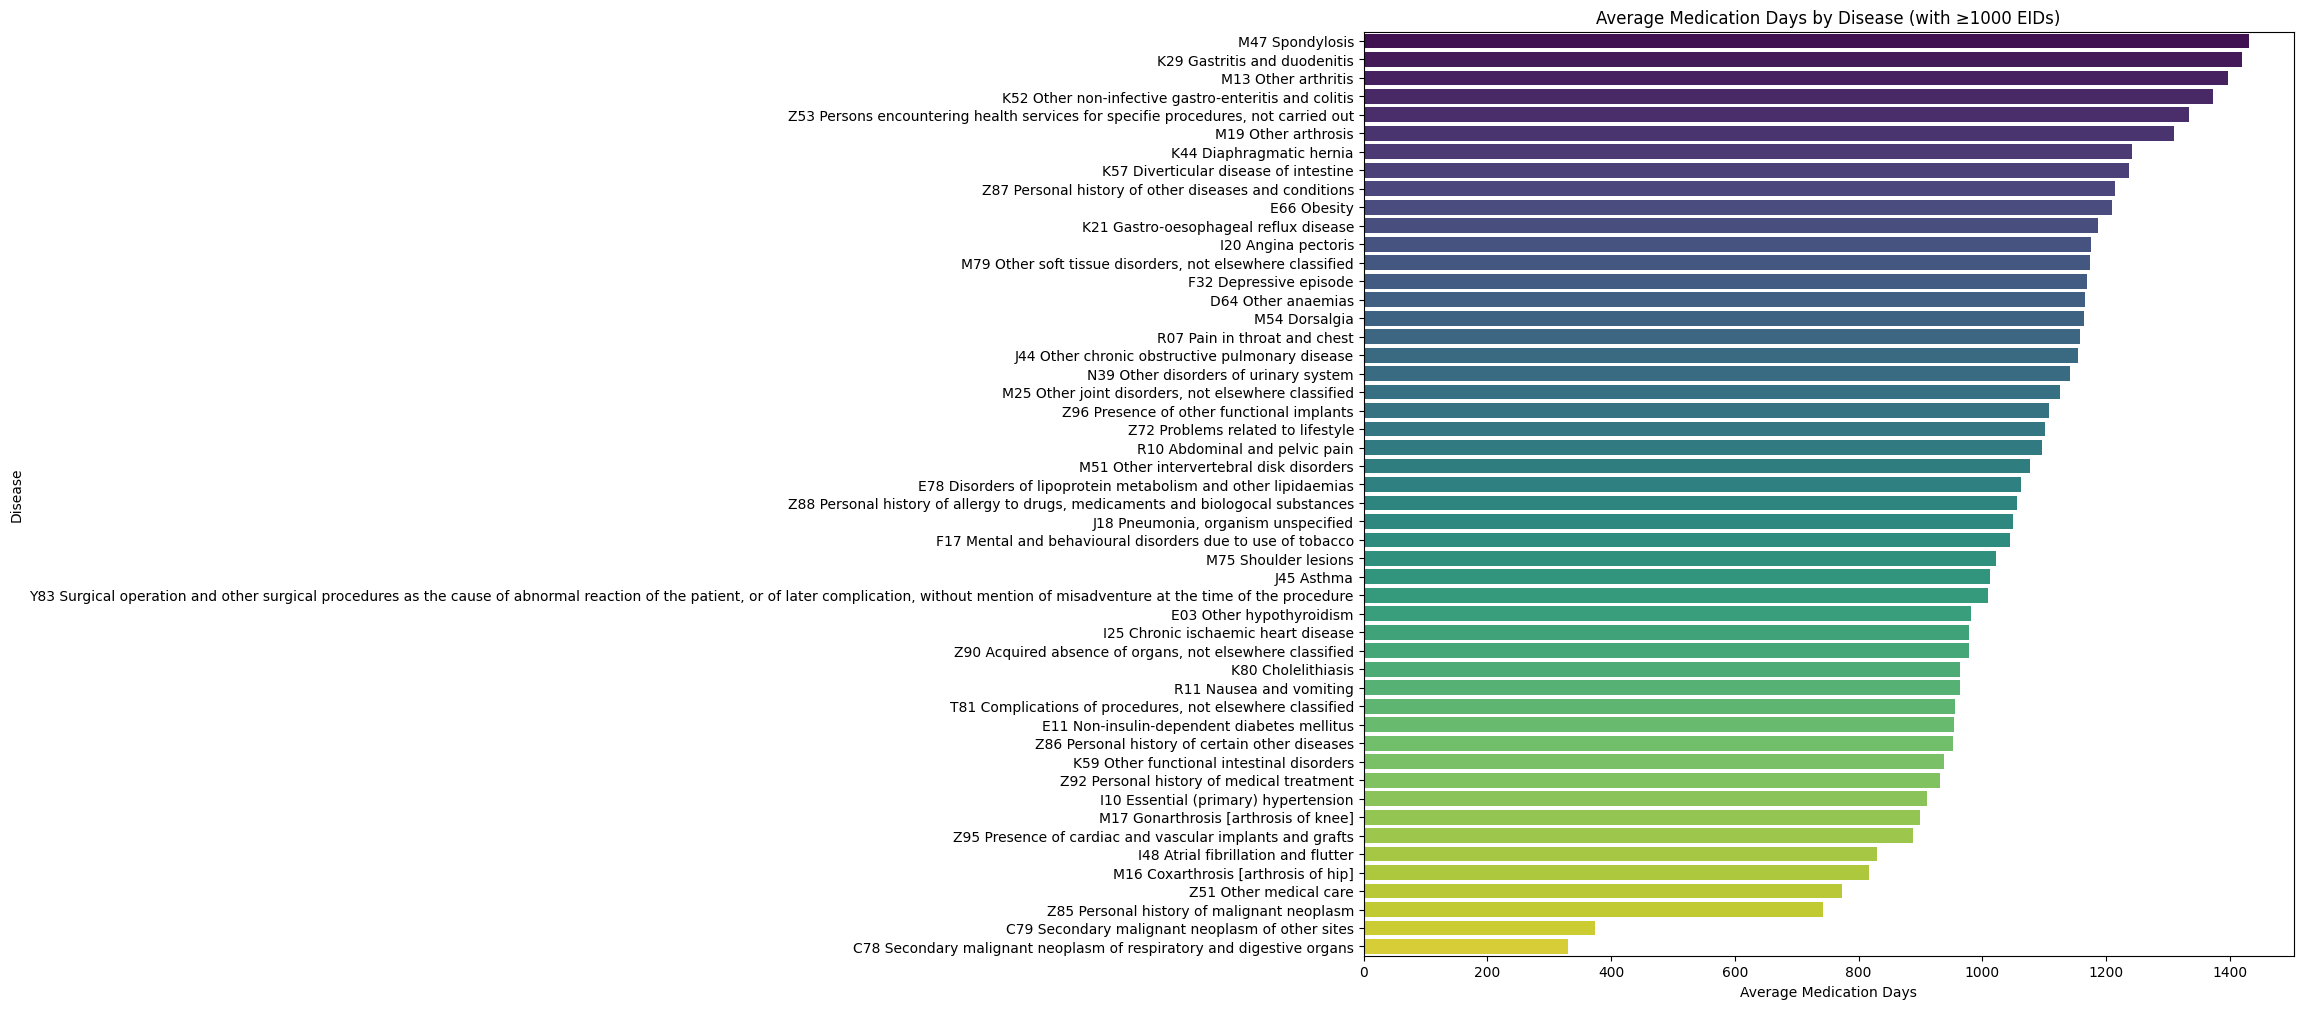

In [ ]:
# Count the number of unique eids for each disease
disease_eid_counts = final_df_exploded.groupby("meaning_disease")["eid"].nunique()

# Keep only diseases with more than 1000 unique eids
diseases_with_more_eids = disease_eid_counts[disease_eid_counts >= 1000].index
df_filtered_diseases = final_df_exploded[
    final_df_exploded["meaning_disease"].isin(diseases_with_more_eids)
]

# Step 1: Prepare stats DataFrame
disease_stats = (
    df_filtered_diseases.groupby("meaning_disease")
    .agg(
        average_med_days=("available_medication_days", "mean"),
        total_users=("eid", "nunique"),
    )
    .reset_index()
    .sort_values("average_med_days", ascending=False)
)

# Step 2: Create the bar plot
plt.figure(figsize=(12, 12))
sns.barplot(
    y=disease_stats["meaning_disease"],
    x=disease_stats["average_med_days"],
    palette="viridis",
)


# Final touches
plt.title("Average Medication Days by Disease (with ≥1000 EIDs)")
plt.xlabel("Average Medication Days")
plt.ylabel("Disease")
plt.show()

/tmp/ipykernel_2306/4007020417.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


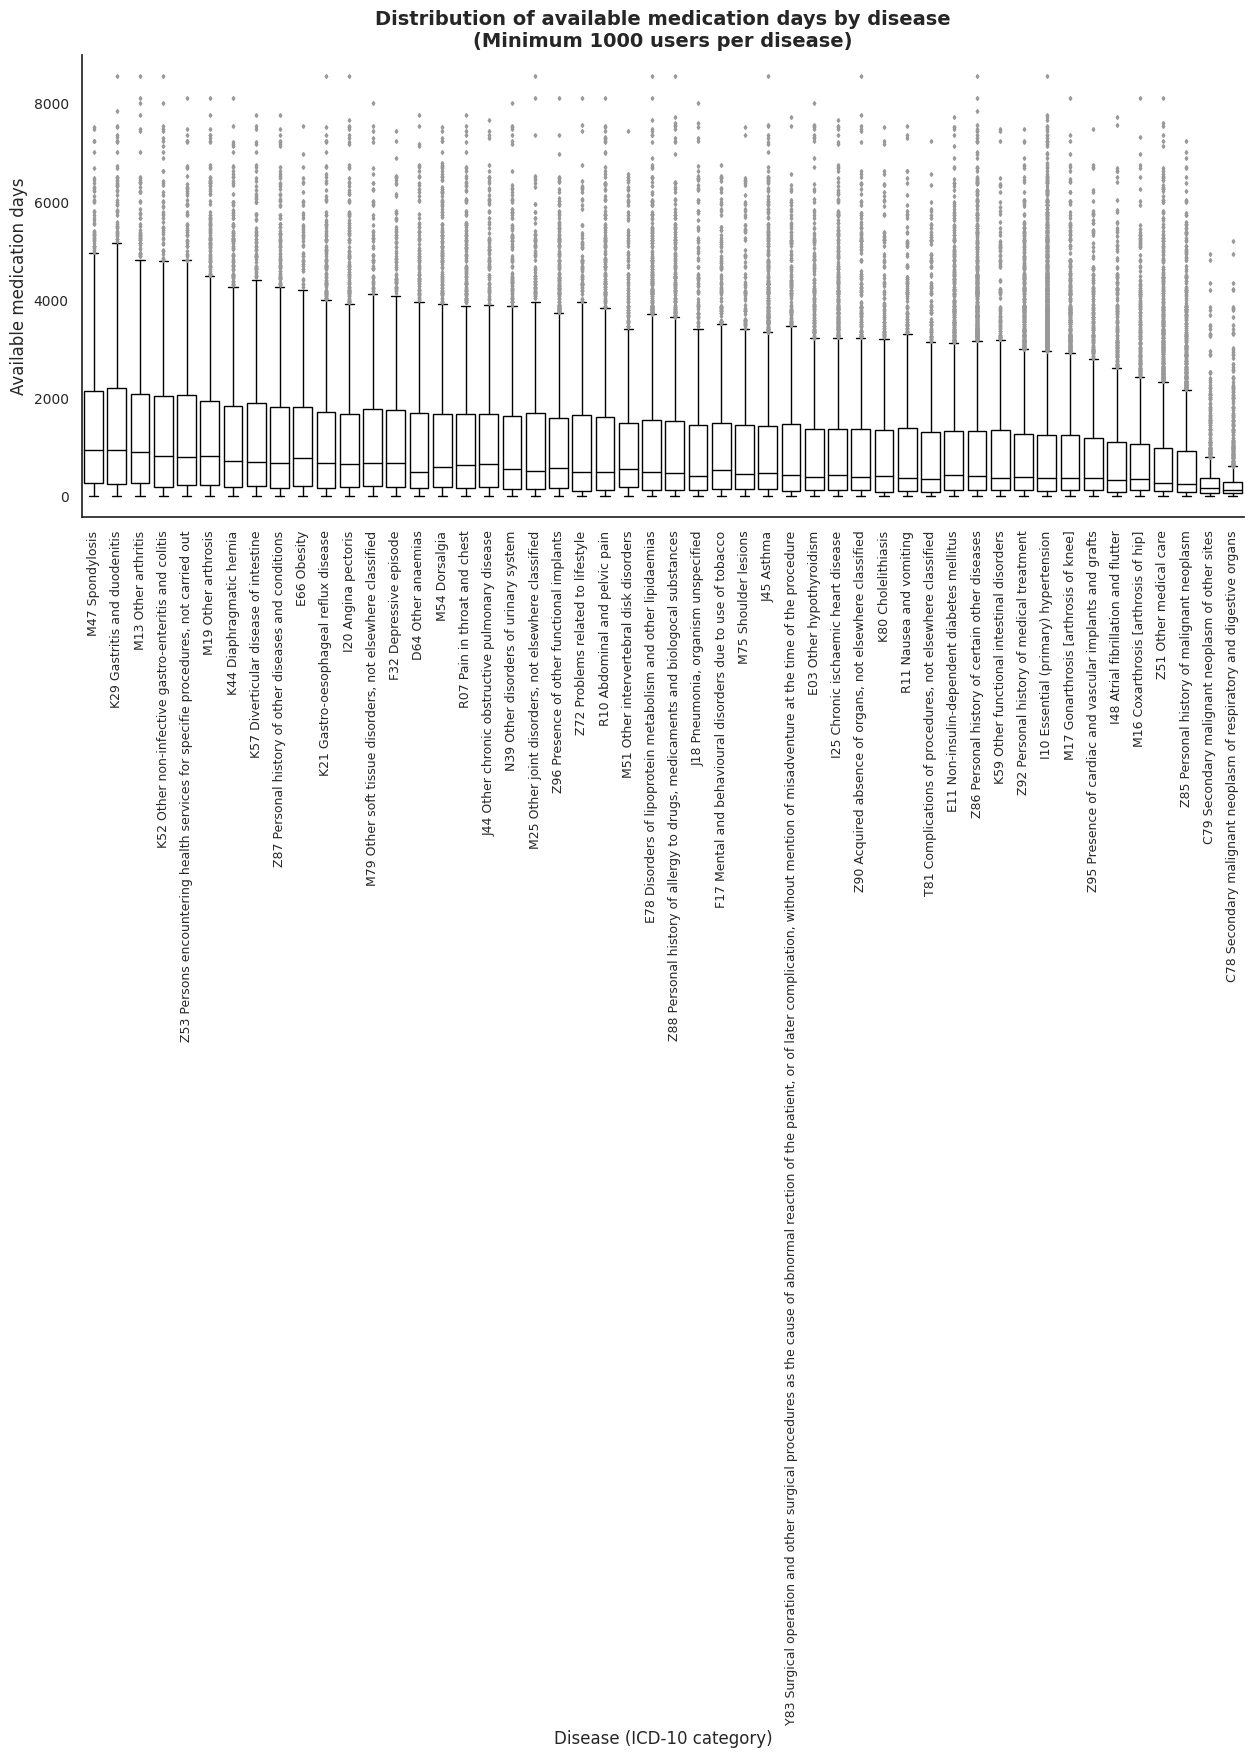

In [ ]:
# Calculate mean medication days and sort diseases
disease_avg = df_filtered_diseases.groupby("meaning_disease")[
    "available_medication_days"
].mean()
sorted_diseases = disease_avg.sort_values(ascending=False).index

# Set plot style
sns.set(style="white", rc={"axes.spines.right": False, "axes.spines.top": False})

# Create the boxplot
plt.figure(figsize=(15, 6))
ax = sns.boxplot(
    x="meaning_disease",
    y="available_medication_days",
    data=df_filtered_diseases,
    order=sorted_diseases,
    color="white",
    fliersize=2,
    linewidth=1,
    boxprops=dict(edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black"),
)

# Format labels
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=10)
plt.xlabel("Disease (ICD-10 category)", fontsize=12)
plt.ylabel("Available medication days", fontsize=12)
plt.title(
    "Distribution of available medication days by disease\n(Minimum 1000 users per disease)",
    fontsize=14,
    fontweight="bold",
)

# Clean layout
plt.tight_layout()

# Save outputs
plt.savefig("boxplot_available_med_days_by_disease.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_2306/4251665474.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


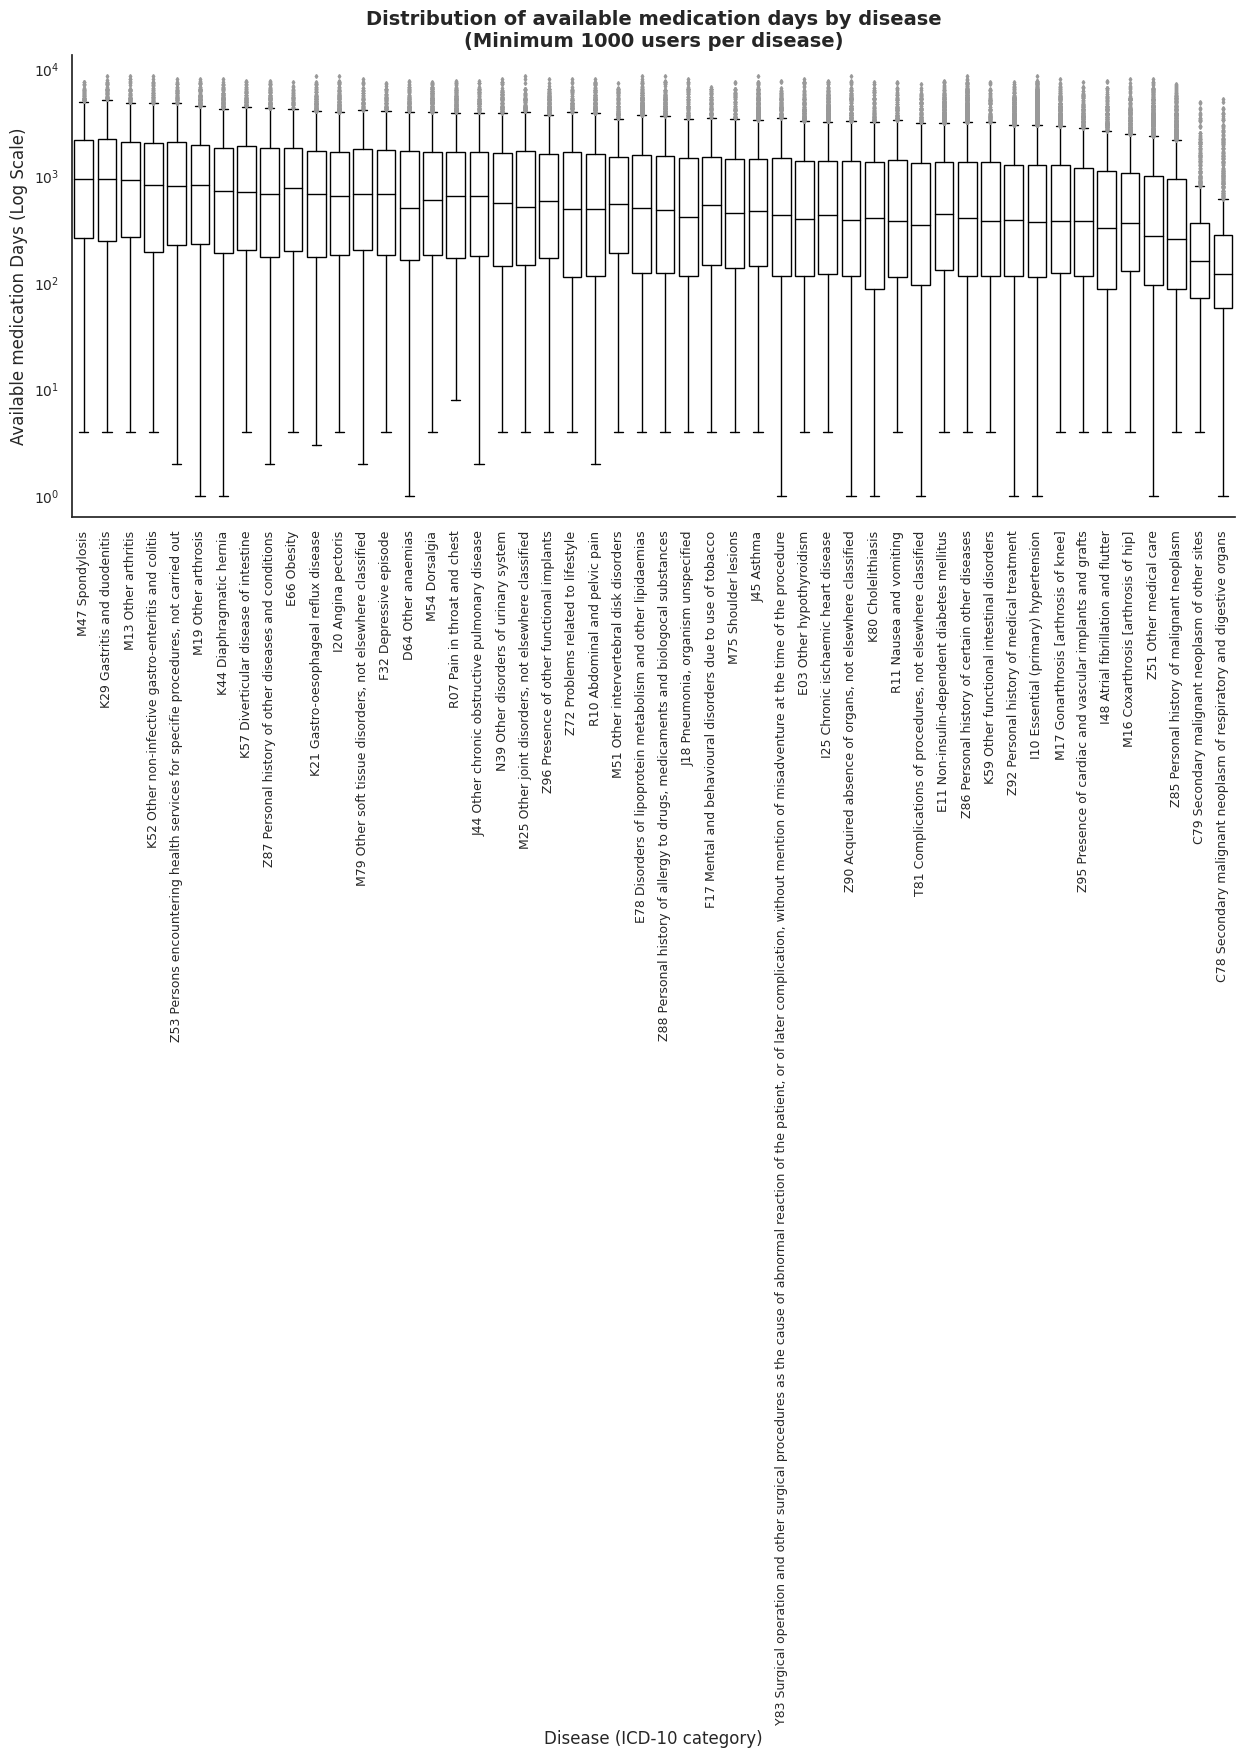

In [ ]:
# Set Seaborn style
sns.set(style="white", rc={"axes.spines.right": False, "axes.spines.top": False})

# Create figure
plt.figure(figsize=(15, 6))
ax = sns.boxplot(
    x="meaning_disease",
    y="available_medication_days",
    data=df_filtered_diseases,
    order=sorted_diseases,
    color="white",
    fliersize=2,
    linewidth=1,
    boxprops=dict(edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black"),
)

# Set log scale for y-axis
ax.set_yscale("log")

# Axis labels and title
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=10)
plt.xlabel("Disease (ICD-10 category)", fontsize=12)
plt.ylabel("Available medication Days (Log Scale)", fontsize=12)
plt.title(
    "Distribution of available medication days by disease\n(Minimum 1000 users per disease)",
    fontsize=14,
    fontweight="bold",
)

# Clean and save
plt.tight_layout()
plt.savefig("boxplot_available_med_days_logscale.png", dpi=300, bbox_inches="tight")
plt.show()

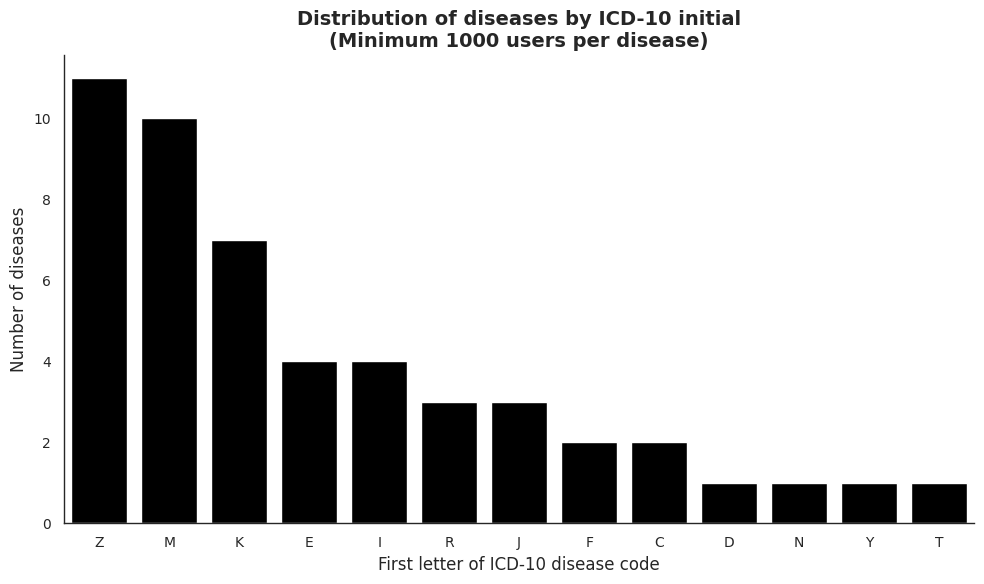

In [ ]:
# Extract first letter and count (descending order)
disease_counts = (
    disease_stats["meaning_disease"].str[0].value_counts().sort_values(ascending=False)
)

# Plot setup
sns.set(style="white")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=disease_counts.index,
    y=disease_counts.values,
    color="black",  # Solid black bars
)

# Title and axis labels
plt.title(
    "Distribution of diseases by ICD-10 initial\n(Minimum 1000 users per disease)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("First letter of ICD-10 disease code", fontsize=12)
plt.ylabel("Number of diseases", fontsize=12)

# Axis ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_locator(MultipleLocator(2))

# Remove unnecessary spines
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)
plt.gca().spines["left"].set_linewidth(1)
plt.gca().spines["bottom"].set_linewidth(1)

# Optional: remove grid or keep minimal
plt.grid(False)

# Save high-quality outputs
plt.tight_layout()
plt.savefig("disease_initial_distribution_blackbars.png", dpi=300, bbox_inches="tight")

plt.show()

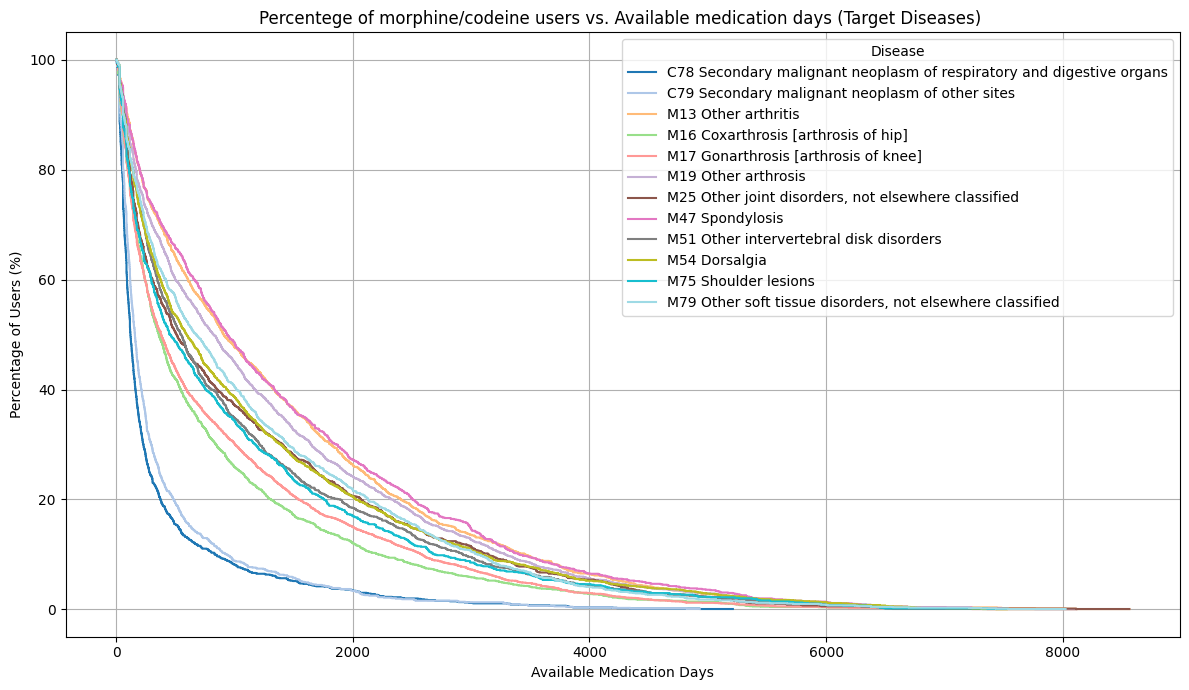

In [ ]:
# Keep all diseases with codes starting with "M"
target_df_M_C = df_filtered_diseases[
    df_filtered_diseases["diag_icd10_level1"].str.startswith(("M", "C"))
]
# Group the filtered data by disease
survival_df_group_disease = target_df_M_C.groupby("meaning_disease")

# Get the list of unique diseases
diseases = sorted(survival_df_group_disease.groups.keys())

# Generate a colormap with enough unique colors
colors = cm.get_cmap(
    "tab20", len(diseases)
)  # You can also try 'nipy_spectral', 'Set3', etc.

plt.figure(figsize=(12, 7))

# Plot each disease with a unique color
for i, (disease, group) in enumerate(survival_df_group_disease):
    group = group.sort_values("available_medication_days")
    survival_counts = (
        group["available_medication_days"]
        .value_counts()
        .sort_index(ascending=False)
        .cumsum()
    )
    survival_counts = survival_counts[::-1]
    survival_percent = (survival_counts / survival_counts.max()) * 100
    plt.step(
        survival_percent.index, survival_percent.values, label=disease, color=colors(i)
    )

plt.xlabel("Available Medication Days")
plt.ylabel("Percentage of Users (%)")
plt.title(
    "Percentege of morphine/codeine users vs. Available medication days (Target Diseases) "
)
plt.legend(title="Disease")
plt.grid(True)
plt.tight_layout()
plt.show()

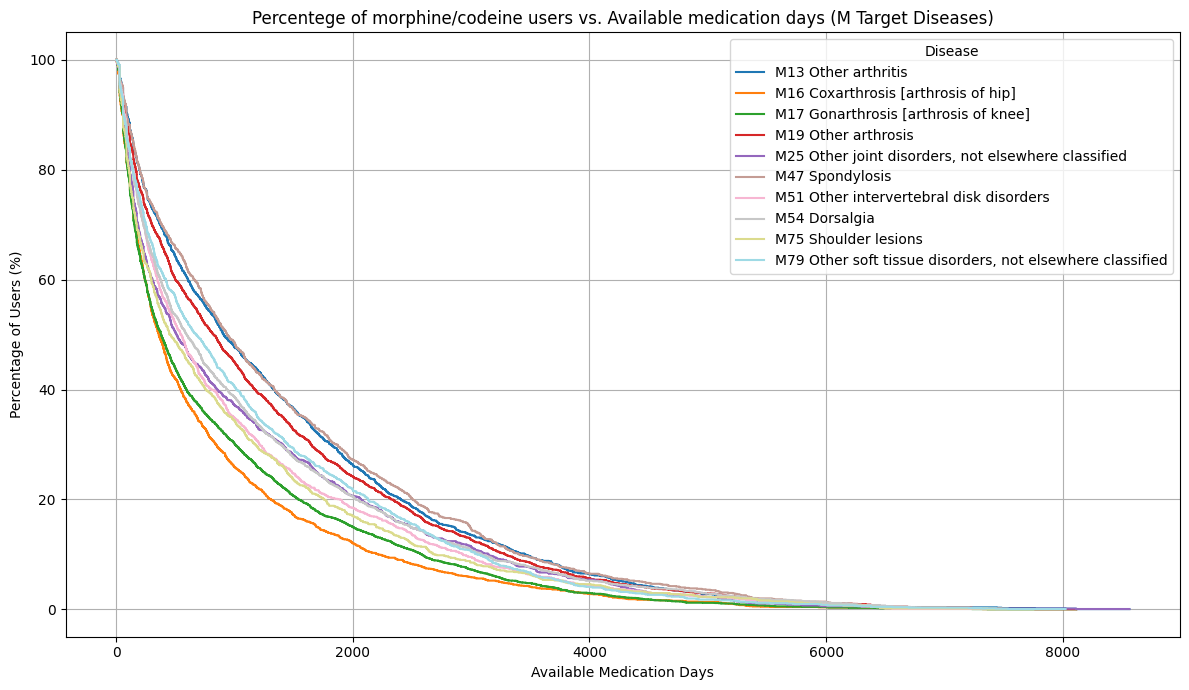

In [ ]:
## Keep all diseases with codes starting with "M"
target_df_M = df_filtered_diseases[
    df_filtered_diseases["diag_icd10_level1"].str.startswith("M")
]
# Group the filtered data by disease
survival_df_group_disease = target_df_M.groupby("meaning_disease")

# Get the list of unique diseases
diseases = sorted(survival_df_group_disease.groups.keys())

# Generate a colormap with enough unique colors
colors = cm.get_cmap(
    "tab20", len(diseases)
)  # You can also try 'nipy_spectral', 'Set3', etc.

plt.figure(figsize=(12, 7))

# Plot each disease with a unique color
for i, (disease, group) in enumerate(survival_df_group_disease):
    group = group.sort_values("available_medication_days")
    survival_counts = (
        group["available_medication_days"]
        .value_counts()
        .sort_index(ascending=False)
        .cumsum()
    )
    survival_counts = survival_counts[::-1]
    survival_percent = (survival_counts / survival_counts.max()) * 100
    plt.step(
        survival_percent.index, survival_percent.values, label=disease, color=colors(i)
    )

plt.xlabel("Available Medication Days")
plt.ylabel("Percentage of Users (%)")
plt.title(
    "Percentege of morphine/codeine users vs. Available medication days (M Target Diseases)"
)
plt.legend(title="Disease")
plt.grid(True)
plt.tight_layout()
plt.show()

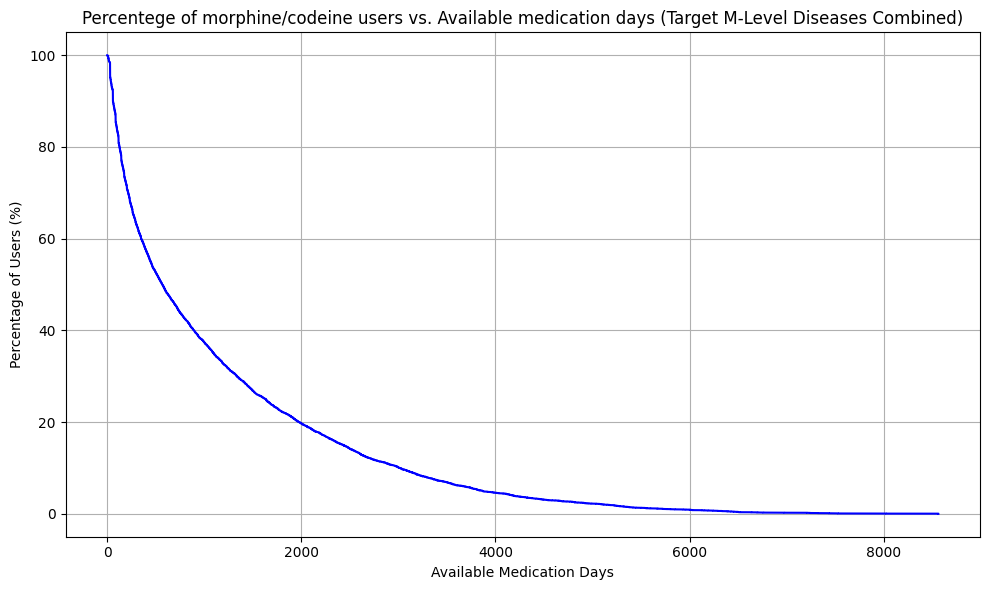

In [ ]:
# Use the same dataset with only "M" level ICD10 codes
target_df_M = df_filtered_diseases[
    df_filtered_diseases["diag_icd10_level1"].str.startswith("M")
]

# Sort by available medication days
target_df_M = target_df_M.sort_values("available_medication_days")

# Compute survival-style cumulative distribution
survival_counts = (
    target_df_M["available_medication_days"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
)
survival_counts = survival_counts[::-1]  # Reverse for increasing x-axis
survival_percent = (survival_counts / survival_counts.max()) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.step(survival_percent.index, survival_percent.values, where="post", color="blue")

plt.xlabel("Available Medication Days")
plt.ylabel("Percentage of Users (%)")
plt.title(
    "Percentege of morphine/codeine users vs. Available medication days (Target M-Level Diseases Combined)"
)
plt.grid(True)
plt.tight_layout()
plt.show()

Now we will save a list of eids diagnosis with the target diseases (in this case the ones starting with M from the previous plot) for further annalysis 

In [ ]:
# Get unique eids
unique_eids_target_diseases_1000_eids = target_df_M["eid"].unique()

# Count the number of unique eids
num_eids_target_diseases = len(unique_eids_target_diseases_1000_eids)
print("Number of unique eids:", num_eids_target_diseases)

# Save the list of unique eids to a text file (one per line)
np.savetxt(
    "unique_eids_target_diseases_M_1000_eids.txt",
    unique_eids_target_diseases_1000_eids,
    fmt="%s",
)

Number of unique eids: 12318


In [41]:
# Upload list
!dx upload unique_eids_target_diseases_M_1000_eids.txt --path WGS_Lucia/Data/phenotypes/

[===========================================================>] Uploaded 98,544 of 98,544 bytes (100%) unique_eids_target_diseases_M_1000_eids.txt
ID                                file-J089Z3QJb4J1gfxXb528ZPxq
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/phenotypes
Name                              unique_eids_target_diseases_M_1000_eids.txt
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Apr 29 09:21:18 2025
Created by                        luciass6
 via the job                      job-J088YZ0Jb4JJv7ff64B5b0j1
Last modified                     Tue Apr 29 09:21:19 2025
Media type                        
archivalState                     "live"
cloudAccount     